In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

From [Altmann et al](http://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0019009&type=printable), the probability that user $i$ used word $w$ at least once is:
\begin{align}
\tilde{U}_i = & 1 - \prod_{j=0}^{N_w-1} (1 - \frac{m_i}{N_a - j})\\
\approx & 1 - e^{-f_w m_i},
\end{align}
where,
- $N_w$ is the count of word $w$
- $N_a$ is the total number of word tokens
- $f_w = N_w / N_a$
- $m_i$ is the total number of words from user $i$

Let's try it out.

In [3]:
N_user = 1000
e_m = 50
N_vocab = 5000
dir_param =0.1

In [4]:
m = np.random.poisson(e_m,N_user)

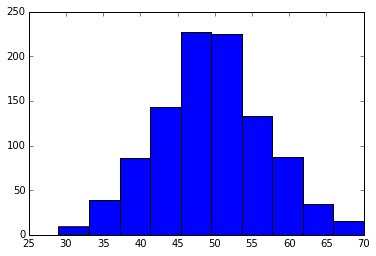

In [5]:
plt.hist(m)
plt.show()

In [6]:
f_w = np.random.dirichlet(dir_param * np.ones(N_vocab))

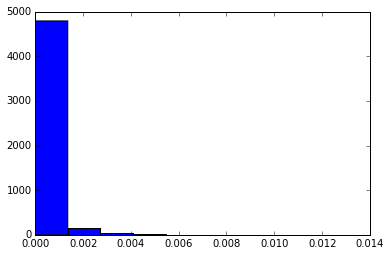

In [7]:
plt.hist(f_w)
plt.show()

In [8]:
x = np.zeros((N_user,N_vocab))

In [9]:
for i in range(N_user):
    x[i,] = np.random.multinomial(m[i],f_w)

In [10]:
U_true = (x>0).sum(axis=0)

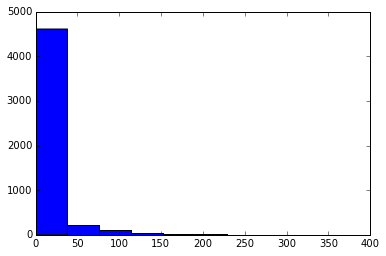

In [14]:
plt.hist(U_true)
plt.show()

In [18]:
test = np.outer(m,f_w)
print(test)
print(test.shape)

[[  6.20351940e-11   9.45960443e-05   1.57253277e-04 ...,   5.35622615e-02
    3.10266122e-05   6.18517113e-03]
 [  5.98585206e-11   9.12768848e-05   1.51735618e-04 ...,   5.16828840e-02
    2.99379592e-05   5.96814758e-03]
 [  4.24451328e-11   6.47236092e-05   1.07594348e-04 ...,   3.66478632e-02
    2.12287347e-05   4.23195920e-03]
 ..., 
 [  6.74768777e-11   1.02893943e-04   1.71047424e-04 ...,   5.82607055e-02
    3.37482449e-05   6.72773000e-03]
 [  7.50952349e-11   1.14511001e-04   1.90359230e-04 ...,   6.48385271e-02
    3.75585306e-05   7.48731242e-03]
 [  5.55051736e-11   8.46385659e-05   1.40700301e-04 ...,   4.79241288e-02
    2.77606530e-05   5.53410049e-03]]
(1000, 5000)


Original approximation from the paper:

In [13]:
U_est1 = (1. - np.exp(-np.outer(m,f_w))).sum(axis=0)

/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


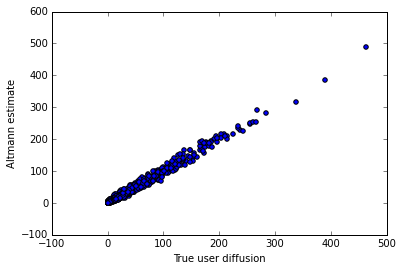

In [14]:
plt.scatter(U_true,U_est1);
plt.xlabel('True user diffusion')
plt.ylabel('Altmann estimate');

## Maclaurin series approximation

https://en.wikipedia.org/wiki/Taylor_series#List_of_Maclaurin_series_of_some_common_functions

In [162]:
from scipy.misc import factorial

In [163]:
# x = value of input to e^x
# n = degree of approximation
def approx(x,n):
    return sum([(x**i) / factorial(i) for i in xrange(n)])

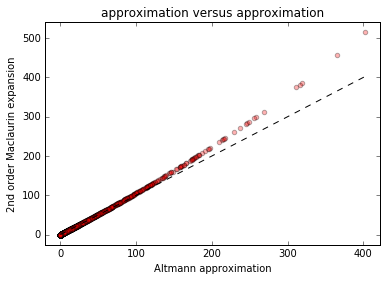

In [178]:
U_est2 = (1. - approx(-np.outer(m,f_w),2)).sum(axis=0)
plt.scatter(U_est1,U_est2,c='r',alpha=.3)
plt.plot([min(U_est1),max(U_est1)],[min(U_est1),max(U_est1)],'k--')
plt.axis('tight');
plt.title('approximation versus approximation')
plt.xlabel('Altmann approximation')
plt.ylabel('2nd order Maclaurin expansion');

Not too bad, but overestimates $\tilde{U}_i$ for large values.

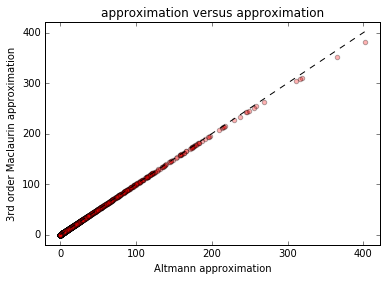

In [179]:
U_est2 = (1. - approx(-np.outer(m,f_w),3)).sum(axis=0)
plt.scatter(U_est1,U_est2,c='r',alpha=.3)
plt.plot([min(U_est1),max(U_est1)],[min(U_est1),max(U_est1)],'k--')
plt.axis('tight');
plt.title('approximation versus approximation')
plt.xlabel('Altmann approximation')
plt.ylabel('3rd order Maclaurin approximation');

better...

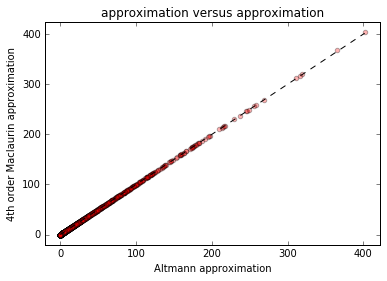

In [180]:
U_est2 = (1. - approx(-np.outer(m,f_w),4)).sum(axis=0)
plt.scatter(U_est1,U_est2,c='r',alpha=.3)
plt.plot([min(U_est1),max(U_est1)],[min(U_est1),max(U_est1)],'k--')
plt.axis('tight');
plt.title('approximation versus approximation')
plt.xlabel('Altmann approximation')
plt.ylabel('4th order Maclaurin approximation');

Even better! Can we use this approximation to speed things up?

\begin{align}
\tilde{U}_i = & 1 - \prod_{j=0}^{N_w-1} (1 - \frac{m_i}{N_a - j})\\
\approx & 1 - e^{-f_w m_i}\\
\approx & 1 - 1 - f_w m_i + \frac{1}{2} (f_w m_i)^2 - \frac{1}{6} (f_w m_i)^3\\
= & -f_w m_i + \frac{1}{2} (f_w m_i)^2 - \frac{1}{6} (f_w m_i)^3\\
\sum_i \tilde{U}_i \approx & -f_w \sum_i m_i + \frac{f_w^2}{2} \sum_i m_i^2 - \frac{f_w^3}{6} \sum_i m_i^3
\end{align}

This means we only need to store the sums $\sum_i m_i$, $\sum_i m_i^2$, and $\sum_i m_i^3$. We can apply these sums to compute the expected user counts for every word.

In [19]:
# compute these once
sum1 = m.sum()
sum2 = (m**2).sum()
sum3 = (m**3).sum()

In [25]:
# reuse them across the vector of word frequencies
U_est3 = f_w * sum1 - .5 * (f_w**2) * sum2 + (1./6)*(f_w**3) * sum3

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


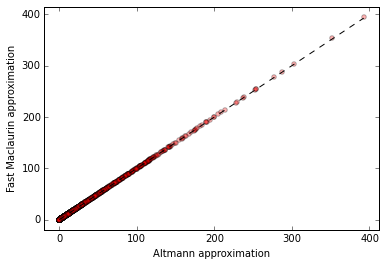

In [26]:
plt.scatter(U_est1,U_est3,c='r',alpha=.3)
plt.plot([min(U_est1),max(U_est1)],[min(U_est1),max(U_est1)],'k--')
plt.axis('tight')
plt.xlabel('Altmann approximation')
plt.ylabel('Fast Maclaurin approximation');

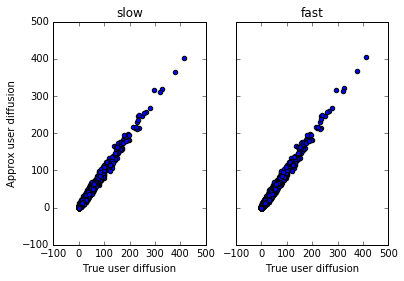

In [186]:
fig,ax = plt.subplots(1,2,sharey=True)
ax[0].scatter(U_true,U_est1)
ax[0].set_title('slow')
ax[0].set_xlabel('True user diffusion')
ax[0].set_ylabel('Approx user diffusion')

ax[1].scatter(U_true,U_est3)
ax[1].set_title('fast');
ax[1].set_xlabel('True user diffusion');

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in divide
  from ipykernel import kernelapp as app


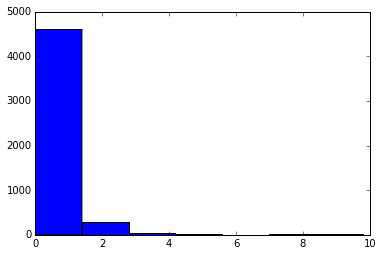

In [23]:
# histogram of actual diffusion
diffusion = U_true / U_est1
diffusion[np.isnan(diffusion)] = 0
plt.figure()
plt.hist(diffusion, bins=80)
plt.xlim(0,10)
plt.show()